Using Python 3.10.15 environment

In [1]:
import numpy as np
from astropy import units as u 
import matplotlib.pyplot as plt
from astropy.visualization import wcsaxes

import numpy as np
from astropy import units as u 
from astropy.io import fits
import matplotlib.pyplot as plt
import colorcet
import matplotlib as mpl
from glob import glob
from astropy.coordinates import SkyCoord

import warnings
warnings.filterwarnings('ignore')   

# from tools import *

plt.style.use('paper.mplstyle')
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True

import sys
sys.path.append('./../modules')
import cat_props, cat_misc

# **LOAD TABLE**

In [2]:
from imports import *
def plot_median_with_percentile_error(ax, data, y=0.07, color1='C0', color2='C0', marker='s',
                                      error_linewidth=2, capsize=5, capthick=2, scatter_linewidth=1.75):
    """
    Plot the median of `data` with error bars representing the 16th and 84th percentiles on a given axis.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes on which to plot.
    data : array-like
        The data from which to compute the median and percentile ranges.
    y : float, optional
        The y-coordinate at which to plot the marker and error bar (default is 0.07).
    color1 : str, optional
        Color for the error bars and marker edge (default is 'C0').
    color2 : str, optional
        Color for the marker face (default is 'C0').
    marker : str, optional
        Marker style for the median point (default is 's').
    error_linewidth : float, optional
        Line width for the error bar (default is 2).
    capsize : float, optional
        The length of the error bar caps in points (default is 5).
    capthick : float, optional
        The thickness of the error bar caps (default is 2).
    scatter_linewidth : float, optional
        The line width for the scatter marker edge (default is 1.75).
    """
    # Compute the median and the 16th and 84th percentiles
    median = np.nanmedian(data)
    p16, p84 = np.nanpercentile(data, [16, 84])
    err_low = median - p16  # Distance from median to 16th percentile
    err_high = p84 - median  # Distance from median to 84th percentile

    # Plot the median with asymmetric error bars representing the 16th and 84th percentiles
    ax.errorbar(median, y, xerr=[[err_low], [err_high]], elinewidth=error_linewidth, 
                capsize=capsize, capthick=capthick, zorder=5, color=color1)
    ax.scatter([median], [y], marker=marker, ec=color1, fc=color2, 
               zorder=5, linewidths=scatter_linewidth)
    
    return
# root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'
root_dir = f'{PROJECTS_PATH}/Extragalactic/'
# table = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue.fits' %root_dir)
table = QTable.read('%s/hstha_nebulae_catalogue/all/nebulae_catalogue_fixediso_10pc.fits' %root_dir)

root_dir = f'{DATA_PATH}/Extragalactic/'
table_muse_masked = QTable.read('%s/catalogues/Nebulae_catalogue_v3/Nebulae_catalogue_v3_HSTFOV.fits' %root_dir)

table = table[(table['flag_star_MUSE']!=1) & (table['flag_edge_MUSE']!=1) & (table["flag_edge_hst"]!=1)] # remove stars and edge objects
table_muse_masked = table_muse_masked[(table_muse_masked['flag_star']!=1) & (table_muse_masked['flag_edge']!=1)] # remove stars and edge objects

print(f'Table length post-masking (inc. stars etc): {len(table)}')
print(f'Table MUSE with HST FOV length post-masking (inc. stars etc): {len(table_muse_masked)}')
# table
# Load sample table 
root_dir = f'{DATA_PATH}/Extragalactic/catalogues/'
sample_table_file = '%s/sample_table/phangs_sample_table_v1p6.fits' %root_dir
sample_table = QTable.read(sample_table_file)

# Load the MUSE table
muscat_table_file = '%s/Nebulae_catalogue_v4/Nebulae_catalogue_v4.fits' %root_dir
table_muse = QTable.read(muscat_table_file)

# Make column names consistent
columns = table_muse.colnames
for column in columns:
    table_muse.rename_column(column, column+'_MUSE')
table_muse.rename_column('gal_name_MUSE', 'gal_name')
table_muse.rename_column('region_ID_MUSE', 'region_ID')
table_muse.rename_column('Lum_HA6562_CORR_MUSE', 'HA6562_LUMINOSITY_MUSE')

# Get radius in pc
for gal_name in np.unique(table_muse['gal_name']):
    mask = sample_table['name'] == gal_name.lower()
    dist = sample_table['dist'][mask][0]
    table_muse['region_circ_rad_pc_MUSE'] = cat_props.calculate_radius(table_muse['region_circ_rad_MUSE'], dist)  

mask_flags = ~((table_muse['flag_edge_MUSE']==1)|(table_muse['flag_star_MUSE']==1))
table_muse = table_muse[mask_flags] 

print(f'Table MUSE length post-masking (inc. stars etc): {len(table_muse)}')

Table length post-masking (inc. stars etc): 5559
Table MUSE with HST FOV length post-masking (inc. stars etc): 25910
Table MUSE length post-masking (inc. stars etc): 30790


# **LOAD DATA**

In [4]:
galaxy_name = 'ngc1566'
region_ID = 1

mask = (table['gal_name'] == galaxy_name.upper()) & (table['region_ID'] == region_ID)
table_masked = table[mask]
ra = table_masked['ra_com']
dec = table_masked['dec_com']
position = SkyCoord(ra=ra, dec=dec, frame='icrs')

root_dir = f'/Users/abarnes/Library/CloudStorage/Dropbox/Data/Extragalactic/{galaxy_name}/'
root_dir_hstcat = '/Users/abarnes/Library/CloudStorage/Dropbox/Projects/Extragalactic/hstha_nebulae_catalogue/'

file_mus = glob(f'{root_dir}/muse/{galaxy_name.upper()}-*_MAPS.fits')[0]

file_hstcat = f'{root_dir_hstcat}/{galaxy_name}/catalogue_fixediso_10pc/{galaxy_name}_mask.fits' 
file_hstcpx = f'{root_dir_hstcat}/{galaxy_name}/catalogue_fixediso_10pc/{galaxy_name}_complexity.fits' 

file_muscat = f'{root_dir}/muse/{galaxy_name.upper()}_nebmask.fits'  

file_hst_f555w = glob(f'{root_dir}/hst/{galaxy_name}_*_f555w_exp_drc_sci.fits')[0]
file_hst_f814w = glob(f'{root_dir}/hst/{galaxy_name}_*_f814w_exp_drc_sci.fits')[0] 
file_hst_ha = f'{root_dir}/hst_contsub/{galaxy_name}_hst_ha_10pc_fixednoise.fits' 


hdu_mus = fits.open(file_mus)['HA6562_FLUX']
hdu_hst = fits.open(file_hst_ha)[0]
hdu_hstcat = fits.open(file_hstcat)[0]
hdu_muscat = fits.open(file_muscat)[0]
hdu_hst_f555w = fits.open(file_hst_f555w)[0]
hdu_hst_f814w = fits.open(file_hst_f814w)[0]

hdu_muscat.data[np.isnan(hdu_muscat.data)] = -1

In [5]:
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

def get_croppeddata(hdu, position, size):

    wcs = WCS(hdu)  # Create a WCS object from the HDU header
    cutout = Cutout2D(hdu.data, position, size , wcs=wcs)  # Create a rectangular cutout
    hdu_crop = fits.PrimaryHDU(cutout.data, cutout.wcs.to_header())

    return hdu_crop  # Return the cropped HDU object

size = 3 * u.arcsec  # Define the size of the cutout in arcseconds
hdu_mus_cropped = get_croppeddata(hdu_mus, position, size=size)
hdu_hst_crop = get_croppeddata(hdu_hst, position, size=size)
hdu_hstcat_crop = get_croppeddata(hdu_hstcat, position, size=size)
hdu_muscat_crop = get_croppeddata(hdu_muscat, position, size=size)
hdu_hst_f555w_crop = get_croppeddata(hdu_hst_f555w, position, size=size)
hdu_hst_f814w_crop = get_croppeddata(hdu_hst_f814w, position, size=size)

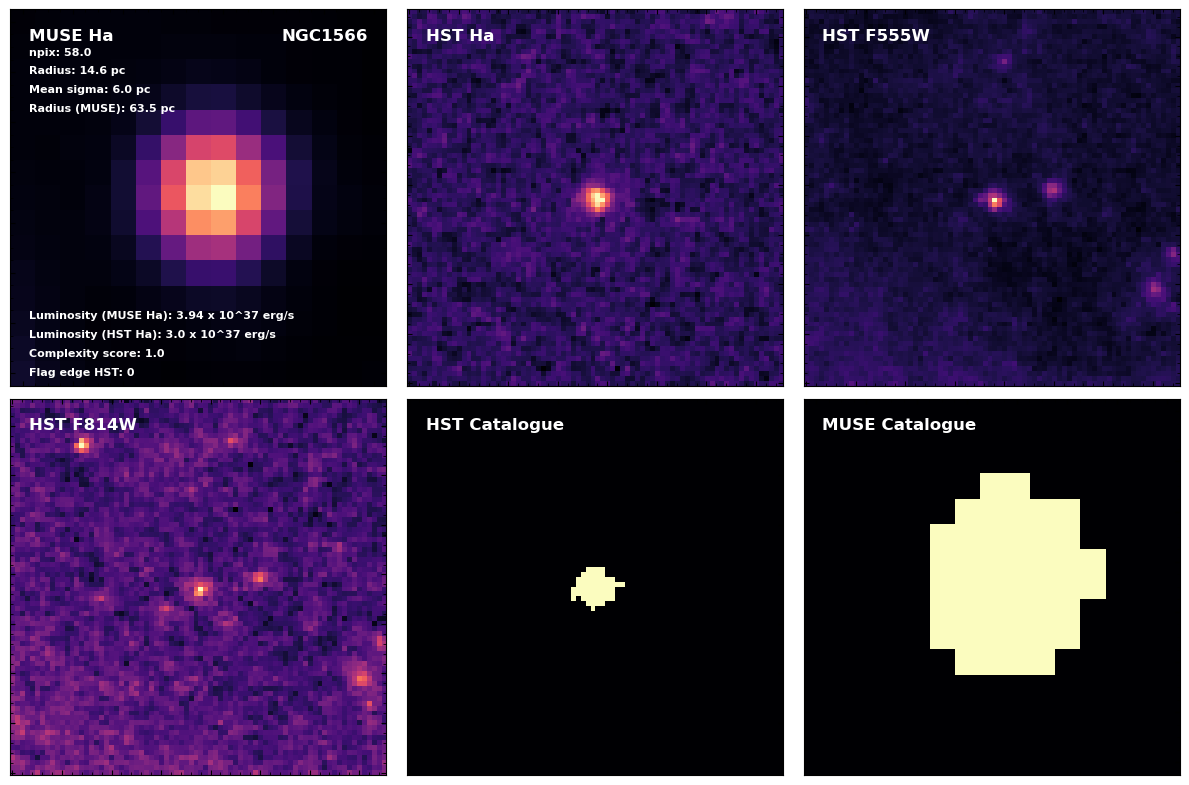

In [26]:
# plot all the images
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()
axs[0].imshow(hdu_mus_cropped.data, origin='lower', cmap='magma')
axs[1].imshow(hdu_hst_crop.data, origin='lower', cmap='magma')
axs[2].imshow(hdu_hst_f555w_crop.data, origin='lower', cmap='magma')
axs[3].imshow(hdu_hst_f814w_crop.data, origin='lower', cmap='magma')
axs[4].imshow(hdu_hstcat_crop.data, origin='lower', cmap='magma')
axs[5].imshow(hdu_muscat_crop.data, origin='lower', cmap='magma')

axs[0].text(0.05, 0.95, 'MUSE Ha', transform=axs[0].transAxes, color='white', fontsize=12, va='top')
axs[1].text(0.05, 0.95, 'HST Ha', transform=axs[1].transAxes, color='white', fontsize=12, va='top')
axs[2].text(0.05, 0.95, 'HST F555W', transform=axs[2].transAxes, color='white', fontsize=12, va='top')
axs[3].text(0.05, 0.95, 'HST F814W', transform=axs[3].transAxes, color='white', fontsize=12, va='top')
axs[4].text(0.05, 0.95, 'HST Catalogue', transform=axs[4].transAxes, color='white', fontsize=12, va='top')
axs[5].text(0.05, 0.95, 'MUSE Catalogue', transform=axs[5].transAxes, color='white', fontsize=12, va='top')

# Get info from the masked table
gal_name = table_masked['gal_name'].value[0].decode().upper()
npix = table_masked['npix'].value[0]
radius_circ = table_masked['radius_circ_pc'].value[0]
mean_sigma_pc = table_masked['mean_sigma_pc'].value[0]
region_circ_rad_pc_MUSE = table_masked['region_circ_rad_pc_MUSE'].value[0]

complexity_score = table_masked['complexity_score'][0]
flag_edge_hst = table_masked['flag_edge_hst'][0]

ha_lum_hst = table_masked['HA6562_LUMINOSITY_HST'].value[0] / 1e37
ha_lum_muse = table_masked['HA6562_LUMINOSITY_MUSE'].value[0] / 1e37

axs[0].text(0.95, 0.95, f'{gal_name.upper()}', transform=axs[0].transAxes, color='white', fontsize=12, va='top', ha='right')
axs[0].text(0.05, 0.90, f'npix: {npix}', transform=axs[0].transAxes, color='white', fontsize=8, va='top')
axs[0].text(0.05, 0.85, f'Radius: {radius_circ:.1f} pc', transform=axs[0].transAxes, color='white', fontsize=8, va='top')
axs[0].text(0.05, 0.80, f'Mean sigma: {mean_sigma_pc:.1f} pc', transform=axs[0].transAxes, color='white', fontsize=8, va='top')
axs[0].text(0.05, 0.75, f'Radius (MUSE): {region_circ_rad_pc_MUSE:.1f} pc', transform=axs[0].transAxes, color='white', fontsize=8, va='top')

axs[0].text(0.05, 0.15, f'Luminosity (HST Ha): {ha_lum_hst:.1f} x 10^37 erg/s', transform=axs[0].transAxes, color='white', fontsize=8, va='top')
axs[0].text(0.05, 0.2, f'Luminosity (MUSE Ha): {ha_lum_muse:.2f} x 10^37 erg/s', transform=axs[0].transAxes, color='white', fontsize=8, va='top')


axs[0].text(0.05, 0.05, f'Flag edge HST: {flag_edge_hst}', transform=axs[0].transAxes, color='white', fontsize=8, va='top')
axs[0].text(0.05, 0.1, f'Complexity score: {complexity_score:.1f}', transform=axs[0].transAxes, color='white', fontsize=8, va='top')

# remove ticks and labels
for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

fig.tight_layout()